# Time series clustering exercise

In [52]:
from __future__ import print_function
# this is me
__author__ = "Sung Hoon Yang, CUSP NYU 2018"

# limit the number of same warnings to once
import warnings
warnings.filterwarnings(action='once')

## bread and butter
import sys
import numpy as np
import pandas as pd
import matplotlib
font = {'weight' : 'bold',
        'size'   : 88}

matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
import pylab as pl
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import statsmodels.formula.api as smf
"""
Set up PUIDATA env var
"""
os.environ["PUIDATA"] = "%s/fall18/PUI/PUIDATA"% os.getenv("HOME")
os.environ["PUI2018"] = "%s/fall18/PUI/PUI2018"% os.getenv("HOME")
%matplotlib inline
np.random.seed(999)

# Utilities
sys.path.insert(0, '/nfshome/shy256/util')
from puma_to_name import PUMA_TO_NAME
from pprint import pprint
import re
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from copy import deepcopy
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering

# Data

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

In [5]:
PUIDATA = os.environ["PUIDATA"]

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


In [6]:
!cd "$PUIDATA"; rm -rf hw12; mkdir hw12; cd hw12; wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip; unzip application%2Fzip; ls

--2018-12-10 18:42:46--  https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.199, 52.206.140.205, 52.206.68.26
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip [following]
--2018-12-10 18:42:46--  https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Reusing existing connection to data.cityofnewyork.us:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘application%2Fzip’

application%2Fzip       [    <=>             ]   1.44M  1.93MB/s    in 0.7s    

2018-12-10 18:42:47 (1.93 MB/s) - ‘application%2Fzip’ saved [1514401]

Archive:  applicati

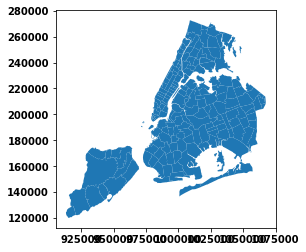

In [7]:
__SHP__ = gpd.read_file(os.path.join(PUIDATA, 'hw12', 'ZIP_CODE_040114.shp'))
__SHP__.plot()

In [8]:
__SHP__.ZIPCODE.unique().size

248

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

In [9]:
x = ['0%d' % e for e in list(range(0, 10))]; x.extend(range(10, 15)); x.extend(range(94, 100))
df = None
!find . -name 'zbp*' -exec rm {} \;
for i in x:
    fn = 'zbp{}totals.zip'.format(i)
    !wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/"$fn"; unzip "$fn"
    _df = pd.read_csv(u'./%s.txt' % fn.split('.')[0])
    globals()['raw_{}'.format(fn.split('.')[0])] = _df

--2018-12-10 18:42:48--  https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp00totals.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW12_fb55/zbp00totals.zip [following]
--2018-12-10 18:42:49--  https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW12_fb55/zbp00totals.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628434 (614K) [application/zip]
Saving to: ‘zbp00totals.zip’

zbp00totals.zip     100%[===================>] 613.71K  --.-KB/s    in 0.02s   

2018-12-10 18:42:49 (33.6 MB/s) - ‘zbp00totals.zip’ saved [628434/628434]

Archive:  zbp00totals.zip


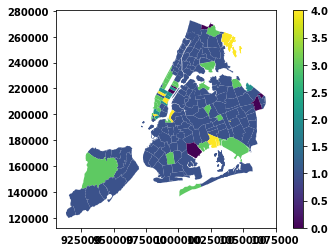

In [51]:
_shp.plot(column='label', cmap='viridis', legend=True)

In [10]:
x = ['0%d' % e for e in list(range(0, 10))]; x.extend(range(10, 15)); x.extend(range(94, 100))
df = None
for i in x:
    _df_nm = 'raw_zbp{}totals'.format(i)
    _df = globals()[_df_nm]
    _c_nm = [c for c in _df.columns if c.lower() == 'est'][0]
    _zip_nm = [c for c in _df.columns if c.lower() == 'zip'][0]
    _new_df = _df[np.isin(_df[_zip_nm].astype(int), __SHP__.ZIPCODE.astype(int))][[_zip_nm, _c_nm]]
    _new_df.set_index(_zip_nm, inplace=True)
    _new_df.rename(
        {
            _c_nm: i
        }
        , axis=1
        , inplace=True
    )
    if df is None:
        df = _new_df
    else:
        df = df.merge(_new_df
                    , how='outer'
                     , left_index=True
                     , right_index=True
        )
    
df.head()

,00,01,02,03,04,05,06,07,08,09,...,11,12,13,14,94,95,96,97,98,99
10001,7317.0,7188.0,7141.0,7084.0,7370.0,7312.0,7415.0,7549.0,7472.0,7305.0,...,7227.0,7235.0,7273.0,7369.0,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0
10002,2277.0,2543.0,2269.0,2402.0,2551.0,2682.0,2686.0,2685.0,2691.0,2775.0,...,2912.0,2954.0,2988.0,2972.0,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0
10003,3683.0,3602.0,3616.0,3704.0,3776.0,3867.0,3909.0,4049.0,4071.0,4099.0,...,4159.0,4214.0,4277.0,4333.0,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0
10004,1294.0,1247.0,1253.0,1252.0,1283.0,1260.0,1311.0,1370.0,1376.0,1379.0,...,1404.0,1442.0,1479.0,1554.0,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0
10005,1287.0,1249.0,1244.0,1200.0,1226.0,1214.0,1259.0,1273.0,1291.0,1274.0,...,1301.0,1273.0,1296.0,1321.0,1076.0,1109.0,1216.0,1227.0,1270.0,1242.0


# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [13]:
__SHP__.ZIPCODE = __SHP__.ZIPCODE.astype(int)
df.index = df.index.astype(int)

In [14]:
# 20 years of data and 263 zipcodes
cbs = __SHP__.set_index('ZIPCODE').merge(df, left_index=True, right_index=True, )
cbs.shape

(260, 33)

In [15]:
cleancsb = cbs[['00', '01','02', '03', '04', '05', '06', '07', '08', '09', 10, 11, 12, 13, 14, 94, 95, 96, 97, 98, 99]]

In [16]:
#cleaning all missing values
cleancsb.head()

,00,01,02,03,04,05,06,07,08,09,...,11,12,13,14,94,95,96,97,98,99
10001,7317.0,7188.0,7141.0,7084.0,7370.0,7312.0,7415.0,7549.0,7472.0,7305.0,...,7227.0,7235.0,7273.0,7369.0,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0
10002,2277.0,2543.0,2269.0,2402.0,2551.0,2682.0,2686.0,2685.0,2691.0,2775.0,...,2912.0,2954.0,2988.0,2972.0,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0
10003,3683.0,3602.0,3616.0,3704.0,3776.0,3867.0,3909.0,4049.0,4071.0,4099.0,...,4159.0,4214.0,4277.0,4333.0,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0
10004,1294.0,1247.0,1253.0,1252.0,1283.0,1260.0,1311.0,1370.0,1376.0,1379.0,...,1404.0,1442.0,1479.0,1554.0,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0
10004,1294.0,1247.0,1253.0,1252.0,1283.0,1260.0,1311.0,1370.0,1376.0,1379.0,...,1404.0,1442.0,1479.0,1554.0,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0


In [18]:
cleancsb_stdz = deepcopy(cleancsb)
for i in range(cleancsb_stdz.shape[0]):
    cleancsb_stdz[
        (cleancsb_stdz == np.inf) |
        (cleancsb_stdz == -np.inf)
    ].iloc[i, :] = np.nan
    cleancsb_stdz.iloc[i, :].fillna(cleancsb_stdz.iloc[i, :].mean(), inplace=True) 
    x = np.array(cleancsb_stdz.iloc[i, :])
    cleancsb_stdz.iloc[i, :] = (x.reshape(1, -1) - x.reshape(1, -1).mean()) / x.reshape(1, -1).std()
cleancsb_stdz.head()

/nfshome/shy256/.conda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


,00,01,02,03,04,05,06,07,08,09,...,11,12,13,14,94,95,96,97,98,99
10001,0.480182,-0.479120,-0.828633,-1.252511,0.874314,0.443000,1.208955,2.205439,1.632833,0.390945,...,-0.189098,-0.129607,0.152978,0.866878,-1.884610,-1.222765,-1.319439,-0.731959,0.011686,-0.144480
10002,-0.498185,0.180396,-0.518594,-0.179303,0.200805,0.534993,0.545197,0.542646,0.557953,0.772242,...,1.121736,1.228881,1.315617,1.274800,-1.755856,-1.666569,-1.411464,-1.079826,-1.197175,-0.987988
10003,-0.470215,-0.734885,-0.689140,-0.401596,-0.166333,0.131013,0.268250,0.725705,0.797591,0.889082,...,1.085135,1.264849,1.470704,1.653687,-1.865454,-1.470082,-1.339380,-0.953811,-0.581311,-0.548636
10004,-0.033090,-0.431386,-0.380540,-0.389014,-0.126309,-0.321219,0.110974,0.610962,0.661808,0.687232,...,0.899091,1.221117,1.534669,2.170247,-1.550004,-1.473734,-1.397465,-1.058490,-1.033067,-0.550027
10004,-0.033090,-0.431386,-0.380540,-0.389014,-0.126309,-0.321219,0.110974,0.610962,0.661808,0.687232,...,0.899091,1.221117,1.534669,2.170247,-1.550004,-1.473734,-1.397465,-1.058490,-1.033067,-0.550027


In [19]:
#then the standardization will look like:
vals = ((cleancsb_stdz.T - cleancsb_stdz.mean(1)) / cleancsb_stdz.std(1)).T
vals.mean(axis=1).mean(),  vals.std(axis=1).mean(), vals.mean(axis=1).shape, vals.std(axis=1).shape

(7.807710237898355e-19, 1.0, (260,), (260,))

vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

In [20]:
vals.iloc[np.where(vals.isna())] = 0
np.where(vals.isna())

(array([], dtype=int64), array([], dtype=int64))

In [21]:
vals.head()

,00,01,02,03,04,05,06,07,08,09,...,11,12,13,14,94,95,96,97,98,99
10001,0.468610,-0.467573,-0.808663,-1.222326,0.853243,0.432324,1.179819,2.152288,1.593481,0.381523,...,-0.184541,-0.126483,0.149292,0.845986,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998
10002,-0.486179,0.176049,-0.506095,-0.174982,0.195965,0.522100,0.532058,0.529569,0.544506,0.753631,...,1.094703,1.199265,1.283911,1.244077,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178
10003,-0.458882,-0.717175,-0.672532,-0.391918,-0.162325,0.127855,0.261785,0.708216,0.778369,0.867655,...,1.058983,1.234367,1.435260,1.613833,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414
10004,-0.032293,-0.420990,-0.371369,-0.379639,-0.123265,-0.313478,0.108300,0.596238,0.645859,0.670669,...,0.877423,1.191688,1.497684,2.117945,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772
10004,-0.032293,-0.420990,-0.371369,-0.379639,-0.123265,-0.313478,0.108300,0.596238,0.645859,0.670669,...,0.877423,1.191688,1.497684,2.117945,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772


In [24]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

range_n_clusters = list(range(2, 15))
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=1066)
    cluster_labels = km.fit_predict(vals)
    #report average Silhouette score
    silhouette_avg = silhouette_score(vals, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))
    print(km.labels_.shape)

For n_clusters =2, the average silhouette_score is :0.5385371050248003
(260,)
For n_clusters =3, the average silhouette_score is :0.5016284826140761
(260,)
For n_clusters =4, the average silhouette_score is :0.3993670298732115
(260,)
For n_clusters =5, the average silhouette_score is :0.31115566615061735
(260,)
For n_clusters =6, the average silhouette_score is :0.24919440679596758
(260,)
For n_clusters =7, the average silhouette_score is :0.24630919712722782
(260,)
For n_clusters =8, the average silhouette_score is :0.14728819152645292
(260,)
For n_clusters =9, the average silhouette_score is :0.14704118714168615
(260,)
For n_clusters =10, the average silhouette_score is :0.19538116677460787
(260,)
For n_clusters =11, the average silhouette_score is :0.15039760789479184
(260,)
For n_clusters =12, the average silhouette_score is :0.27686021552304146
(260,)
For n_clusters =13, the average silhouette_score is :0.14655234315193297
(260,)
For n_clusters =14, the average silhouette_score is

#### I would first choose 2 as the cluster number

### silhouette_score is the highest at cluster = 2

In [25]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km_2 = KMeans(n_clusters=2, random_state=1066)
cluster_labels = km_2.fit_predict(vals)
km_2.labels_.shape

km_5 = KMeans(n_clusters=5, random_state=1066)
cluster_labels = km_5.fit_predict(vals)
km_5.labels_.shape

(260,)

### The map of the clusters may look something like this

In [26]:
km_5.labels_

array([3, 1, 1, 1, 1, 1, 1, 3, 2, 4, 1, 2, 3, 3, 2, 3, 4, 2, 1, 2, 3, 2,
       2, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 2, 1, 1, 1, 4,
       1, 1, 0, 0, 0, 4, 0, 1, 0, 2, 4, 0, 2, 0, 0, 0, 0, 2, 2, 3, 1, 2,
       3, 0, 2, 2, 2, 3, 2, 2, 0, 1, 0, 0, 4, 2, 2, 1, 0, 2, 2, 1, 0, 2,
       1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 4, 0, 3, 4, 3, 2, 3, 2, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 4, 4, 4, 1, 3, 1, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 0, 1, 3, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       3, 4, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 3], dtype=int32)

### Figure 3: 
cloropleth of  cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

In [27]:
_vals = vals.merge(
    pd.DataFrame(
        data={
            'label': km_5.labels_
        }
        , index=vals.index
    )
    , left_index=True    
    , right_index=True    
)
_vals.head()

,00,01,02,03,04,05,06,07,08,09,...,12,13,14,94,95,96,97,98,99,label
10001,0.468610,-0.467573,-0.808663,-1.222326,0.853243,0.432324,1.179819,2.152288,1.593481,0.381523,...,-0.126483,0.149292,0.845986,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,3
10002,-0.486179,0.176049,-0.506095,-0.174982,0.195965,0.522100,0.532058,0.529569,0.544506,0.753631,...,1.199265,1.283911,1.244077,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,1
10003,-0.458882,-0.717175,-0.672532,-0.391918,-0.162325,0.127855,0.261785,0.708216,0.778369,0.867655,...,1.234367,1.435260,1.613833,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,1
10004,-0.032293,-0.420990,-0.371369,-0.379639,-0.123265,-0.313478,0.108300,0.596238,0.645859,0.670669,...,1.191688,1.497684,2.117945,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,1
10004,-0.032293,-0.420990,-0.371369,-0.379639,-0.123265,-0.313478,0.108300,0.596238,0.645859,0.670669,...,1.191688,1.497684,2.117945,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,1


0
1
2
3
4


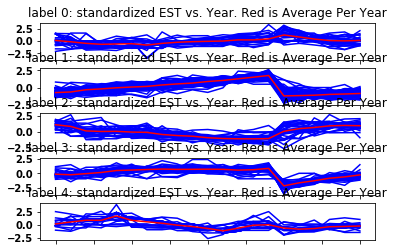

In [49]:
for i, l in enumerate(range(len(set(km_5.labels_)))):
    _ax = plt.subplot('51%d' % (i + 1))
    print(i)
    _vals[_vals.label == i].iloc[:, :-1].T.plot(c='b', ax=_ax)
    pd.Series(_vals[_vals.label == i].iloc[:, :-1].mean(axis=0), index=vals.columns).plot(c='r', ax=_ax)
    _ax.get_legend().remove()
    _ax.set_title('label %d: standardized EST vs. Year. Red is Average Per Year' % i)


#### five clusters' individual time series are drawn in blue, where as red is the average

In [50]:
_shp = __SHP__.merge(
    pd.DataFrame(
        data={
            'label': km_5.labels_
        }
        , index=vals.index
    )
    , left_on='ZIPCODE'
    , right_index=True    
)

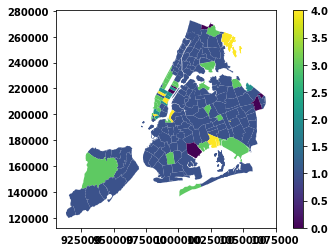

In [51]:
_shp.plot(column='label', cmap='viridis', legend=True)

#### The clustering results on the geopandas map.

# If you want to use agglomerative clustering

In [62]:
agc = AgglomerativeClustering(n_clusters=5, linkage='average').fit(vals)
labelsag = agc.labels_
centroidsag = np.zeros((2, vals.shape[1]))

In [63]:
labelsag

array([2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 3, 2, 2, 3, 2, 1, 3, 2, 3, 1, 3,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 2, 1,
       2, 2, 0, 0, 0, 1, 0, 2, 0, 3, 1, 0, 3, 0, 0, 3, 3, 3, 3, 2, 2, 3,
       2, 2, 3, 3, 3, 2, 3, 3, 0, 2, 0, 0, 1, 3, 3, 2, 0, 3, 3, 2, 0, 3,
       2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 3, 2, 3, 2, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2])

In [64]:
_agg_shp = __SHP__.merge(
    pd.DataFrame(
        data={
            'label': labelsag
        }
        , index=vals.index
    )
    , left_on='ZIPCODE'
    , right_index=True    
)

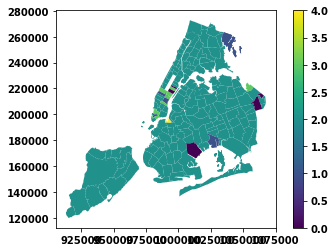

In [65]:
_agg_shp.plot(column='label', cmap='viridis', legend=True)

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

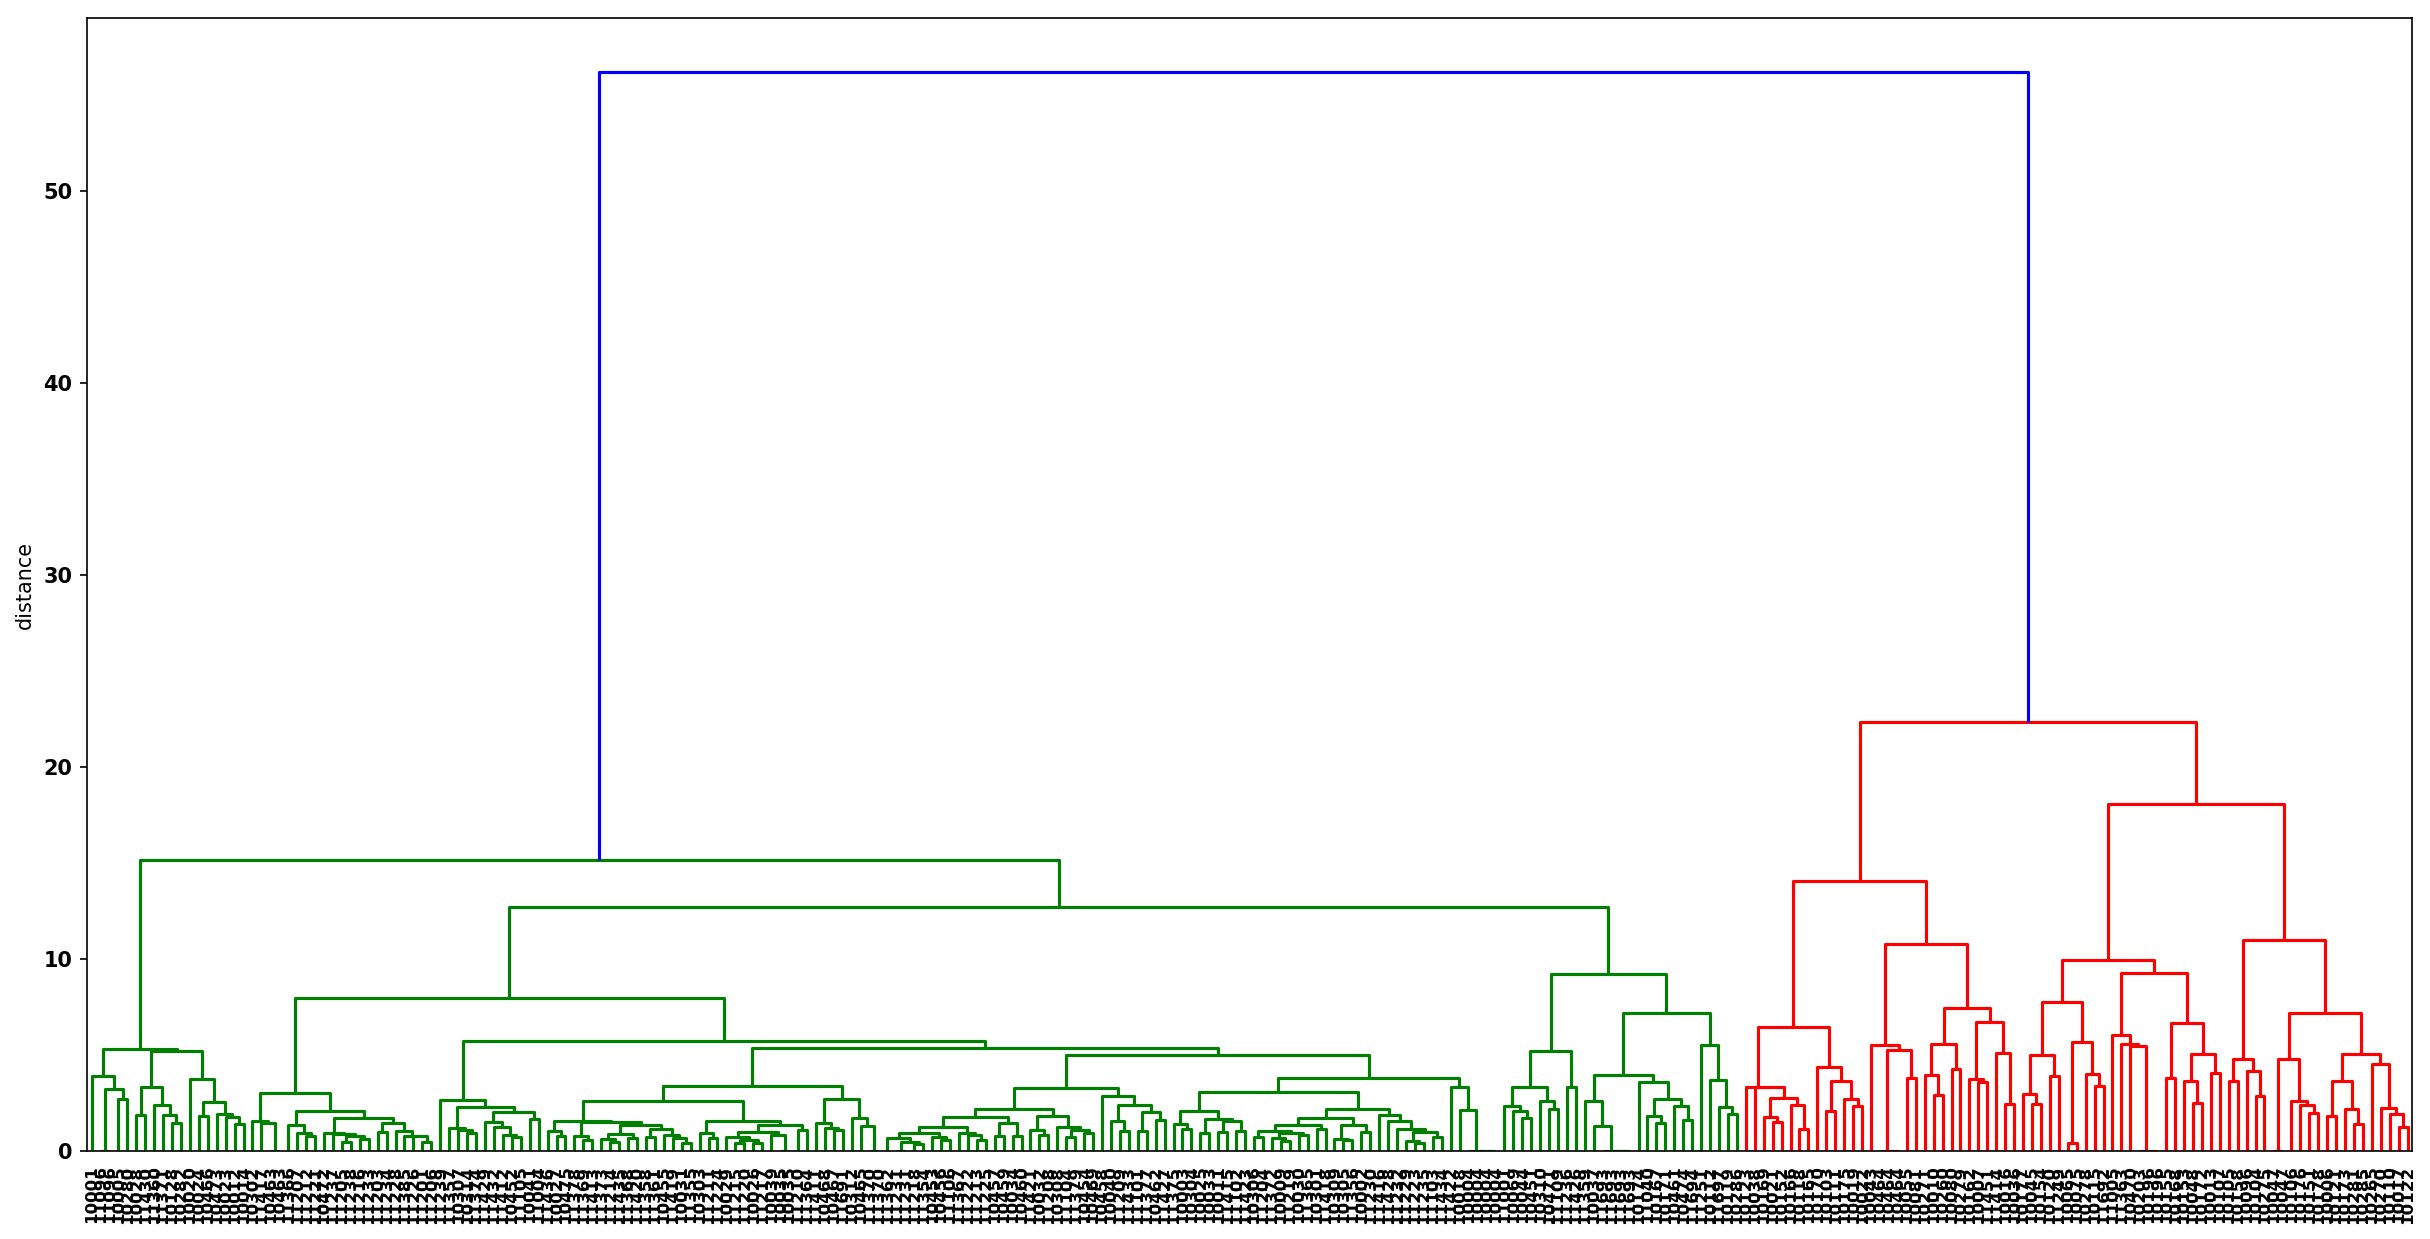

In [68]:
import scipy.cluster as scp
fig = pl.figure(figsize=(20,10), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = vals.index,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels)


In [ ]:
## End of Notebook